In [339]:
import sys
import pandas as pd
import numpy as np
import datetime
from sodapy import Socrata
import geopandas
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests

In [250]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

## Part 1

In [360]:
def retrieve_crime_data():
    #Retrieve Data from API (chicago data portal)
    client = Socrata("data.cityofchicago.org", None)
    results = client.get("6zsd-86xi", where="year=2017 OR year=2018", limit=1000000)
    results_df = pd.DataFrame.from_records(results)
    
    return results_df

In [361]:
def clean_crimes_data(raw_data):
    #clean dates
    results_df['date_formatted'] = pd.to_datetime(results_df['date'])
    results_df['month'] = results_df['date_formatted'].dt.month
    results_df['week'] = results_df['date_formatted'].dt.week

    #specify types and order for each column
    clean = results_df[['id', 
                      'case_number',
                      'date_formatted',
                      'month',
                      'week',
                      'year',
                      'block', 
                      'iucr',
                      'primary_type',
                      'description',
                      'location_description',
                      'arrest',
                      'domestic',
                      'beat',
                      'district',
                      'ward',
                      'community_area',
                      'fbi_code',
                      'x_coordinate',
                      'y_coordinate',
                      'latitude',
                      'longitude']]

    convert_dict = {
                    'id' : 'int',
                  'case_number': 'str',
                  'block': 'str', 
                  'iucr' : 'str',
                  'primary_type' : 'str',
                  'description' : 'str',
                  'location_description' :'str',
                  'arrest' : 'bool',
                  'domestic' : 'bool',
                  'beat' : 'str' ,
                  'district' : 'str',
                  'ward' : 'str',
                  'community_area' : 'str',
                  'fbi_code' : 'str',
                  'x_coordinate' : 'float',
                  'y_coordinate' : 'float',
                  'latitude' : 'float',
                  'longitude' : 'float'}

    clean = clean.astype(convert_dict)

    clean['coordinates'] = list(zip(clean.longitude, clean.latitude))
    clean['coordinates'] = clean['coordinates'].apply(Point)
    clean = geopandas.GeoDataFrame(clean, geometry='coordinates')

    return clean

### Create Crimes Dataset

In [362]:
results_df = retrieve_crime_data()
clean = clean_crimes_data(results_df)

### Create Summary statistics of type of crime per year

In [363]:
def crime_type_change_table(crime_df):
    
    year_groups = clean.groupby(['year', 'primary_type'])
    value_counts = year_groups.agg({'primary_type' : 'count'})
    by_type = value_counts.unstack(level=0)
    by_type = by_type['primary_type'].reset_index()
    by_type["percent_change"] = (by_type['2018'] - by_type['2017'])/by_type['2017']
    by_type = by_type.sort_values(by="2017", ascending=False)
    pd.options.display.max_rows = 32
    
    return by_type

In [371]:
crime_type_change_table(clean)

year,primary_type,2017,2018,percent_change
30,THEFT,64346,65082,0.011438
2,BATTERY,49214,49781,0.011521
6,CRIMINAL DAMAGE,29042,27806,-0.042559
1,ASSAULT,19303,20377,0.055639
8,DECEPTIVE PRACTICE,19028,18736,-0.015346
23,OTHER OFFENSE,17227,17130,-0.005631
3,BURGLARY,13000,11730,-0.097692
27,ROBBERY,11877,9682,-0.184811
17,NARCOTICS,11658,12988,0.114085
16,MOTOR VEHICLE THEFT,11406,9988,-0.124321


In [373]:
def bar_crime_by_type_perc_change(crime_df):
    crimes_perc_change = plt.bar(by_type["primary_type"], by_type["percent_change"])
    return crimes_perc_change
    #Come back to this to make the types of crimes visible

<BarContainer object of 32 artists>

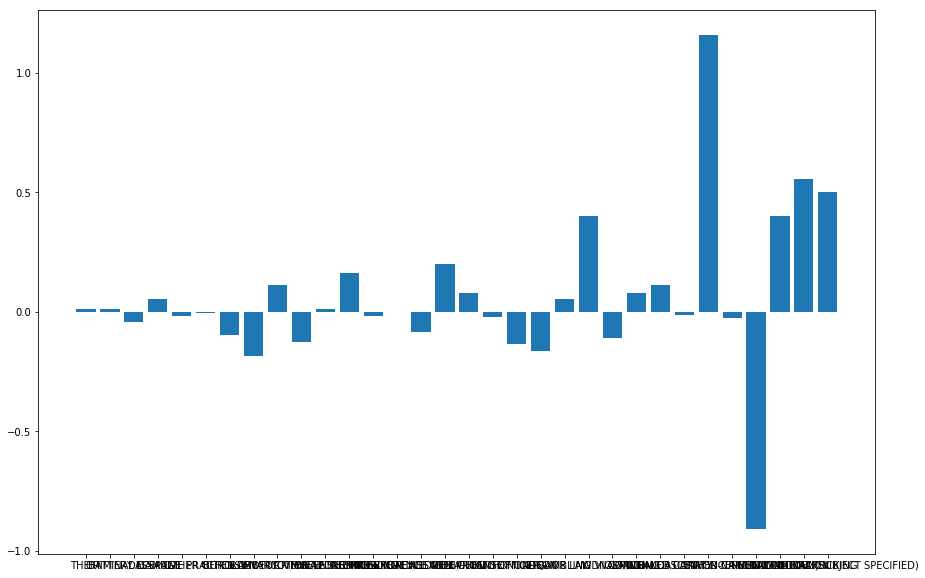

In [374]:
bar_crime_by_type_perc_change(clean)

In [375]:
def plot_crime_month_year_change(crime_df): 
    clean['month-year'] = clean['date_formatted'].dt.to_period("M")
    crimes_my = clean.groupby("month-year").agg({'case_number': 'count'})
    crimes_my = crimes_my.rename(columns={"case_number" : "number_crimes"})
    crimes_my = crimes_my.reset_index()
    
    return crimes_my.plot('month-year', 'number_crimes')

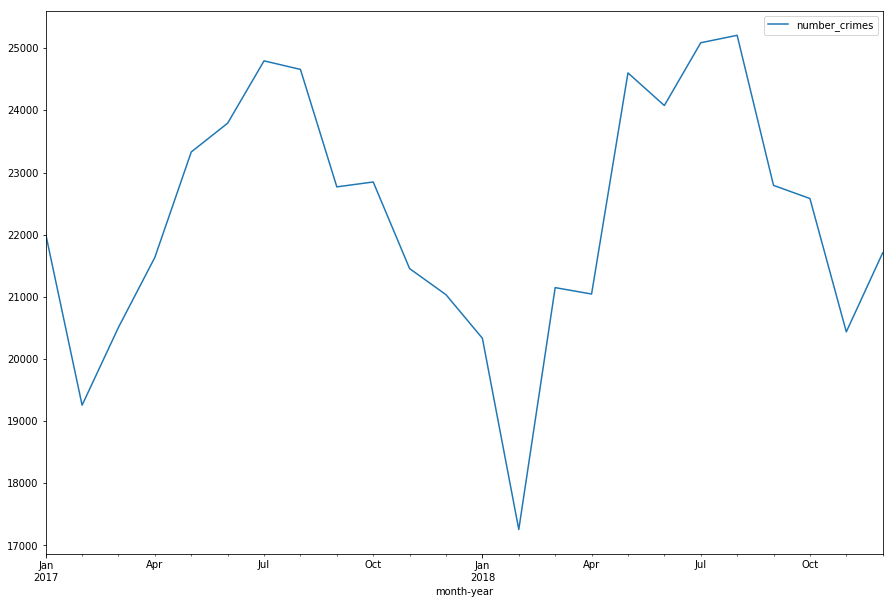

In [376]:
plot_crime_month_year_change(clean)

In [369]:
def total_crime_by_year(crime_df):
    total_crimes = by_type.agg({"2017" : "sum", "2018" : "sum"}).to_frame(name="total_crimes").reset_index()
    
    return total_crimes

In [445]:
total_crimes = total_crime_by_year(clean)

In [446]:
def calc_crime_by_year(crime_df):
    total_crimes_perc_change = ((crime_df['total_crimes'].iloc[1] - crime_df['total_crimes'].iloc[0])/ \
                                crime_df['total_crimes'].iloc[0])*100
    
    return total_crimes_perc_change

In [447]:
calc_crime_by_year(total_crimes)

-0.6781153019813798

# Part 2

### Create dataset with Crimes and Block Group Data

In [381]:
def cr_crimes_w_blocks(crimes_df, block_group_shape_file):
    #drop reported crimes with missing gps coordinates
    missing_gps = crimes_df.latitude.notnull()
    crimes_loc = crimes_df[missing_gps]
    #read in shapefile, downloaded from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2018&layergroup=Block+Groups
    #block_shape = geopandas.read_file("tl_2018_17_bg/tl_2018_17_bg.shp")
    block_shape = geopandas.read_file(block_group_shape_file)
    crimes_w_blocks = geopandas.sjoin(crimes_loc, block_shape , how="inner", op='intersects')
    
    return crimes_w_blocks

In [382]:
#read in shapefile, downloaded from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2018&layergroup=Block+Groups
crimes_w_blocks = cr_crimes_w_blocks(clean, "tl_2018_17_bg/tl_2018_17_bg.shp")

In [383]:
crimes_w_blocks

,id,case_number,date_formatted,month,week,year,block,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,11162428,JA529032,2017-11-28 21:43:00,11,48,2017,026XX S CALIFORNIA BLVD,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
570,11204954,JB116615,2018-01-14 18:00:00,1,2,2018,026XX S KEDZIE AVE,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
6081,10808658,JA107780,2017-01-07 21:15:00,1,1,2017,026XX S CALIFORNIA AVE,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
7531,10811515,JA110662,2017-01-10 13:00:00,1,2,2017,026XX S CALIFORNIA AVE,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
7710,10818154,JA118537,2017-01-15 16:00:00,1,2,2017,031XX W 27TH ST,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
8437,10822435,JA123049,2017-01-20 12:30:00,1,3,2017,027XX S WHIPPLE ST,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
9142,10823388,JA124307,2017-01-21 12:15:00,1,3,2017,028XX S TROY ST,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
9195,10823456,JA124570,2017-01-21 10:00:00,1,3,2017,026XX S CALIFORNIA AVE,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
9877,10824371,JA125677,2017-01-22 14:53:00,1,3,2017,031XX W 31ST ST,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661
10080,10824626,JA126061,2017-01-22 20:15:00,1,3,2017,026XX S CALIFORNIA AVE,...,Block Group 1,G5030,S,1890170,143193,+41.8409834,-087.6975661


In [257]:
crimes_w_blocks = geopandas.sjoin(crimes_loc, block_shape , how="inner", op='intersects')

/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [258]:
crimes_w_blocks.columns

Index(['id', 'case_number', 'date_formatted', 'month', 'week', 'year', 'block',
       'iucr', 'primary_type', 'description', 'location_description', 'arrest',
       'domestic', 'beat', 'district', 'ward', 'community_area', 'fbi_code',
       'x_coordinate', 'y_coordinate', 'latitude', 'longitude', 'coordinates',
       'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON'],
      dtype='object')

### Retrieve and Clean ACS Data

In [291]:
request_obj = requests.get("https://api.census.gov/data/2017/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_012E,B03002_004E,B23025_003E,B23025_004E,B23025_005E,B19013_001E&for=block%20group:*&in=state:17%20county:031")
json_obj = request_obj.json()
acs_data = pd.DataFrame(json_obj)
#clean up
new_header = acs_data.iloc[0] 
acs_data = acs_data[1:] 
acs_data.columns = new_header
rename_dict = {"B03002_001E" : "tot_pop", "B03002_003E" : "non_his_white", "B03002_012E" : "hispanic", "B03002_004E" : "black",
               "B23025_003E" : "labor_force", "B23025_004E" : "employed", "B23025_005E" : "unemployed", "B19013_001E" : "median_hh_income"}
acs_data = acs_data.rename(columns=rename_dict)
data_types = {'tot_pop' : 'int', 'non_his_white' : 'int', 'hispanic' : 'int', 'black' : 'int',
       'labor_force' : 'int', 'employed' : 'int', 'unemployed' : 'int', 'median_hh_income': 'int'}
acs_data = acs_data.astype(data_types)
#create a tract-block var
acs_data['tract-block'] = acs_data['tract'] + acs_data['block group']#clean median income
#clean median income
acs_data['median_hh_income'] = np.where(acs_data['median_hh_income']==-666666666, np.nan,acs_data['median_hh_income'])


### Merge with crime data

In [260]:
acs_data.columns


Index(['NAME', 'tot_pop', 'non_his_white', 'hispanic', 'black', 'labor_force',
       'employed', 'unemployed', 'median_hh_income', 'state', 'county',
       'tract', 'block group', 'tract-block'],
      dtype='object', name=0)

In [450]:
#go back and put this in the cleaning crimes part of the notebook. doesn't belong here
#could make different functions for each of these cleans
crimes_w_blocks = crimes_w_blocks.rename(columns={'TRACTCE' : "tract", 'BLKGRPCE': 'block group'})
crimes_w_blocks['tract-block'] = crimes_w_blocks['tract'] + crimes_w_blocks['block group']

In [ ]:
# year_groups = crimes_w_blocks.groupby(['year', 'primary_type', 'tract-block'])
# block_sum_table = year_groups.agg({'case_number' : 'count'})
# block_sum_table = block_sum_table.unstack(level=0).fillna(value=0)
# block_sum_table

In [ ]:
#crimes_w_blocks is the full crime dataset to use.
#First doing analysis over full dataset, then over time

In [452]:
block_groups = crimes_w_blocks.groupby(['year','primary_type', 'tract-block'])
block_sum_table = block_groups.agg({'case_number' : 'count'})
block_sum_table = block_sum_table.reset_index()

,year,primary_type,tract-block,case_number
0,2017,ARSON,0103004,1
1,2017,ARSON,0202003,1
2,2017,ARSON,0307031,1
3,2017,ARSON,0308002,1
4,2017,ARSON,0403003,1
5,2017,ARSON,0404023,1
6,2017,ARSON,0505005,1
7,2017,ARSON,0621003,1
8,2017,ARSON,0632006,1
9,2017,ARSON,0701021,1


In [453]:
crimes_acs = block_sum_table.merge(acs_data, how='left', on=["tract-block"])

In [454]:
crimes_acs

,year,primary_type,tract-block,case_number,NAME,tot_pop,non_his_white,...,employed,unemployed,median_hh_income,state,county,tract,block group
0,2017,ARSON,0103004,1,"Block Group 4, Census Tract 103, Cook County, ...",1857,638,...,1128,0,51250.0,17,031,010300,4
1,2017,ARSON,0202003,1,"Block Group 3, Census Tract 202, Cook County, ...",1741,966,...,776,19,110313.0,17,031,020200,3
2,2017,ARSON,0307031,1,"Block Group 1, Census Tract 307.03, Cook Count...",968,553,...,635,24,40859.0,17,031,030703,1
3,2017,ARSON,0308002,1,"Block Group 2, Census Tract 308, Cook County, ...",1457,1100,...,613,12,112936.0,17,031,030800,2
4,2017,ARSON,0403003,1,"Block Group 3, Census Tract 403, Cook County, ...",908,423,...,411,65,110106.0,17,031,040300,3
5,2017,ARSON,0404023,1,"Block Group 3, Census Tract 404.02, Cook Count...",1516,1138,...,1076,0,125964.0,17,031,040402,3
6,2017,ARSON,0505005,1,"Block Group 5, Census Tract 505, Cook County, ...",954,737,...,442,0,96553.0,17,031,050500,5
7,2017,ARSON,0621003,1,"Block Group 3, Census Tract 621, Cook County, ...",1395,1064,...,988,61,63095.0,17,031,062100,3
8,2017,ARSON,0632006,1,"Block Group 6, Census Tract 632, Cook County, ...",1668,1195,...,1122,41,54063.0,17,031,063200,6
9,2017,ARSON,0701021,1,"Block Group 1, Census Tract 701.02, Cook Count...",1202,1000,...,932,16,65556.0,17,031,070102,1


In [459]:
crimes_acs_demo = add_demographic_columns(crimes_acs)
crimes_acs_demo

,year,primary_type,tract-block,case_number,NAME,tot_pop,non_his_white,...,county,tract,block group,perc_white,perc_black,perc_hispanic,unemployment_rate
0,2017,ARSON,0103004,1,"Block Group 4, Census Tract 103, Cook County, ...",1857,638,...,031,010300,4,34.356489,18.201400,32.094777,0.000000
1,2017,ARSON,0202003,1,"Block Group 3, Census Tract 202, Cook County, ...",1741,966,...,031,020200,3,55.485353,0.919012,17.576106,2.389937
2,2017,ARSON,0307031,1,"Block Group 1, Census Tract 307.03, Cook Count...",968,553,...,031,030703,1,57.128099,10.847107,25.206612,3.641882
3,2017,ARSON,0308002,1,"Block Group 2, Census Tract 308, Cook County, ...",1457,1100,...,031,030800,2,75.497598,7.412491,9.883322,1.920000
4,2017,ARSON,0403003,1,"Block Group 3, Census Tract 403, Cook County, ...",908,423,...,031,040300,3,46.585903,2.973568,9.801762,13.655462
5,2017,ARSON,0404023,1,"Block Group 3, Census Tract 404.02, Cook Count...",1516,1138,...,031,040402,3,75.065963,0.000000,4.023747,0.000000
6,2017,ARSON,0505005,1,"Block Group 5, Census Tract 505, Cook County, ...",954,737,...,031,050500,5,77.253669,0.000000,19.392034,0.000000
7,2017,ARSON,0621003,1,"Block Group 3, Census Tract 621, Cook County, ...",1395,1064,...,031,062100,3,76.272401,6.021505,10.250896,5.815062
8,2017,ARSON,0632006,1,"Block Group 6, Census Tract 632, Cook County, ...",1668,1195,...,031,063200,6,71.642686,4.796163,12.529976,3.525365
9,2017,ARSON,0701021,1,"Block Group 1, Census Tract 701.02, Cook Count...",1202,1000,...,031,070102,1,83.194676,0.748752,7.737105,1.687764


In [464]:
primary_type_group = crimes_acs.groupby(["primary_type", "year"]).agg({"perc_white" : "mean",
                                                             "perc_black" : "mean",
                                                              "perc_hispanic": "mean",
                                                              "unemployment_rate" : "mean",
                                                             "median_hh_income" : "mean"})

In [468]:
primary_type_group

perc_white  perc_black  perc_hispanic  \
primary_type                      year                                          
ARSON                             2017   15.786810   49.320383      30.393701   
                                  2018   14.433714   52.599598      28.435714   
ASSAULT                           2017   29.352530   37.042145      26.647392   
                                  2018   29.564127   36.884701      26.510123   
BATTERY                           2017   31.246610   35.528064      26.063132   
                                  2018   31.361802   35.499134      26.008054   
BURGLARY                          2017   29.883563   36.575289      26.519510   
                                  2018   30.191868   36.386941      26.314833   
CONCEALED CARRY LICENSE VIOLATION 2017   22.534227   47.852114      26.245281   
                                  2018    7.482490   73.713373      14.714688   
CRIM SEXUAL ASSAULT               2017   25.064382   45.679508      22.668439   
                                  2018   25.079421   46.347784      22.197721   
CRIMINAL DAMAGE                   2017   31.148706   35.572870      26.212753   
                                  2018   31.063088   35.665731      26.147689   
CRIMINAL TRESPASS                 2017   28.862170   40.125015      23.969125   
                                  2018   30.038177   38.854856      24.074197   
...                                            ...         ...            ...   
PROSTITUTION                      2017   11.150960   61.112689      23.836222   
                                  2018   12.402399   59.596955      24.519273   
PUBLIC INDECENCY                  2017   35.889335   22.143079      28.268652   
                                  2018   47.195950   27.682582      14.541661   
PUBLIC PEACE VIOLATION            2017   19.769885   50.735823      23.483561   
                                  2018   22.453890   49.763523      22.043555   
ROBBERY                           2017   27.430149   39.258720      26.251383   
                                  2018   26.243388   40.557748      26.304754   
SEX OFFENSE                       2017   26.283154   39.523455      27.119183   
                                  2018   27.541583   40.038816      25.720827   
STALKING                          2017   26.455045   49.413885      17.369005   
                                  2018   25.464535   49.873011      17.296801   
THEFT                             2017   31.851485   35.060549      25.937191   
                                  2018   31.767069   35.144477      25.942572   
WEAPONS VIOLATION                 2017   14.976332   53.678920      26.544267   
                                  2018   15.750969   51.350908      27.739014   

                                        unemployment_rate  median_hh_income  
primary_type                      year                                       
ARSON                             2017          16.167640      43644.101124  
                                  2018          16.355774      41835.773973  
ASSAULT                           2017          12.123721      55218.804370  
                                  2018          12.122109      55197.351037  
BATTERY                           2017          11.766732      56767.947546  
                                  2018          11.784534      56754.376318  
BURGLARY                          2017          12.021666      56257.746945  
                                  2018          12.024388      56281.137825  
CONCEALED CARRY LICENSE VIOLATION 2017          16.032205      45208.235294  
                                  2018          21.116967      38405.689655  
CRIM SEXUAL ASSAULT               2017          13.575479      51573.298864  
                                  2018          13.558326      50465.120318  
CRIMINAL DAMAGE                   2017          11.801708      56797.897535  
                                  

In [469]:
over_time = primary_type_group.reset_index()
over_time[over_time['primary_type']=="BATTERY"]

,primary_type,year,perc_white,perc_black,perc_hispanic,unemployment_rate,median_hh_income
4,BATTERY,2017,31.246610,35.528064,26.063132,11.766732,56767.947546
5,BATTERY,2018,31.361802,35.499134,26.008054,11.784534,56754.376318


In [470]:
over_time[over_time['primary_type']=="HOMICIDE"]

,primary_type,year,perc_white,perc_black,perc_hispanic,unemployment_rate,median_hh_income
20,HOMICIDE,2017,8.391375,67.342787,21.096403,18.495039,37736.521127
21,HOMICIDE,2018,9.603989,67.828359,19.033256,18.898462,37391.816754


### This analysis clumps years together and answers questions 1, 2, and 4. 

In [274]:
block_groups = crimes_w_blocks.groupby(['primary_type', 'tract-block'])
block_sum_table = block_groups.agg({'case_number' : 'count'})
block_sum_table = block_sum_table.reset_index()
block_sum_table

,primary_type,tract-block,case_number
0,ARSON,0101002,2
1,ARSON,0103004,1
2,ARSON,0107024,1
3,ARSON,0202003,1
4,ARSON,0202004,1
5,ARSON,0205003,1
6,ARSON,0206011,1
...,...,...,...
34211,WEAPONS VIOLATION,8439001,12
34212,WEAPONS VIOLATION,8439002,6


In [292]:
crimes_acs = block_sum_table.merge(acs_data, how='left', on=["tract-block"])

In [293]:
crimes_acs

,primary_type,tract-block,case_number,NAME,tot_pop,non_his_white,hispanic,...,employed,unemployed,median_hh_income,state,county,tract,block group
0,ARSON,0101002,2,"Block Group 2, Census Tract 101, Cook County, ...",2170,707,122,...,826,126,20716.0,17,031,010100,2
1,ARSON,0103004,1,"Block Group 4, Census Tract 103, Cook County, ...",1857,638,596,...,1128,0,51250.0,17,031,010300,4
2,ARSON,0107024,1,"Block Group 4, Census Tract 107.02, Cook Count...",998,186,458,...,503,49,39063.0,17,031,010702,4
3,ARSON,0202003,1,"Block Group 3, Census Tract 202, Cook County, ...",1741,966,306,...,776,19,110313.0,17,031,020200,3
4,ARSON,0202004,1,"Block Group 4, Census Tract 202, Cook County, ...",1453,550,0,...,878,81,64019.0,17,031,020200,4
5,ARSON,0205003,1,"Block Group 3, Census Tract 205, Cook County, ...",1691,341,240,...,489,130,23221.0,17,031,020500,3
6,ARSON,0206011,1,"Block Group 1, Census Tract 206.01, Cook Count...",2008,1231,253,...,1056,49,60852.0,17,031,020601,1
7,ARSON,0206023,1,"Block Group 3, Census Tract 206.02, Cook Count...",1677,400,392,...,635,61,38750.0,17,031,020602,3
8,ARSON,0209013,1,"Block Group 3, Census Tract 209.01, Cook Count...",2362,526,873,...,1247,71,47083.0,17,031,020901,3
9,ARSON,0209022,1,"Block Group 2, Census Tract 209.02, Cook Count...",2130,1013,326,...,1080,101,40050.0,17,031,020902,2


In [277]:
def add_demographic_columns(df):
    #create summary columns
    df['perc_white'] = (df['non_his_white']/df['tot_pop'])*100
    df['perc_black'] = (df['black']/df['tot_pop'])*100
    df['perc_hispanic'] = (df['hispanic']/df['tot_pop'])*100
    df['unemployment_rate'] = (df['unemployed']/df['labor_force'])*100
    
    return df

In [294]:
crimes_acs_demo = add_demographic_columns(crimes_acs)

In [456]:
crimes_acs_demo.columns

Index(['year', 'primary_type', 'tract-block', 'case_number', 'NAME', 'tot_pop',
       'non_his_white', 'hispanic', 'black', 'labor_force', 'employed',
       'unemployed', 'median_hh_income', 'state', 'county', 'tract',
       'block group', 'perc_white', 'perc_black', 'perc_hispanic',
       'unemployment_rate'],
      dtype='object')

,primary_type,tract-block,case_number,NAME,tot_pop,non_his_white,hispanic,...,county,tract,block group,perc_white,perc_black,perc_hispanic,unemployment_rate
0,ARSON,0101002,2,"Block Group 2, Census Tract 101, Cook County, ...",2170,707,122,...,031,010100,2,32.580645,59.539171,5.622120,13.235294
1,ARSON,0103004,1,"Block Group 4, Census Tract 103, Cook County, ...",1857,638,596,...,031,010300,4,34.356489,18.201400,32.094777,0.000000
2,ARSON,0107024,1,"Block Group 4, Census Tract 107.02, Cook Count...",998,186,458,...,031,010702,4,18.637275,31.362725,45.891784,8.876812
3,ARSON,0202003,1,"Block Group 3, Census Tract 202, Cook County, ...",1741,966,306,...,031,020200,3,55.485353,0.919012,17.576106,2.389937
4,ARSON,0202004,1,"Block Group 4, Census Tract 202, Cook County, ...",1453,550,0,...,031,020200,4,37.852719,36.545079,0.000000,8.446298
5,ARSON,0205003,1,"Block Group 3, Census Tract 205, Cook County, ...",1691,341,240,...,031,020500,3,20.165582,31.460674,14.192785,21.001616
6,ARSON,0206011,1,"Block Group 1, Census Tract 206.01, Cook Count...",2008,1231,253,...,031,020601,1,61.304781,1.693227,12.599602,4.434389
7,ARSON,0206023,1,"Block Group 3, Census Tract 206.02, Cook Count...",1677,400,392,...,031,020602,3,23.852117,15.921288,23.375075,8.764368
8,ARSON,0209013,1,"Block Group 3, Census Tract 209.01, Cook Count...",2362,526,873,...,031,020901,3,22.269263,17.569856,36.960203,5.386950
9,ARSON,0209022,1,"Block Group 2, Census Tract 209.02, Cook Count...",2130,1013,326,...,031,020902,2,47.558685,8.685446,15.305164,8.552075


### Look at average block demographics by crime reported

In [296]:
primary_type_group = crimes_acs.groupby("primary_type").agg({"perc_white" : "mean",
                                                             "perc_black" : "mean",
                                                              "perc_hispanic": "mean",
                                                              "unemployment_rate" : "mean",
                                                             "median_hh_income" : "mean"})
pd.options.display.max_rows = 32
primary_type_group

,perc_white,perc_black,perc_hispanic,unemployment_rate,median_hh_income
primary_type,,,,,
ARSON,16.076806,49.455826,29.711632,15.877810,43669.681338
ASSAULT,30.946248,35.640790,26.327513,11.843194,56305.235863
BATTERY,31.949299,35.014154,25.884580,11.671896,57196.400000
BURGLARY,30.982171,35.557155,26.343044,11.795514,56866.710744
CONCEALED CARRY LICENSE VIOLATION,11.738012,67.032090,17.322754,19.766581,40370.168067
CRIM SEXUAL ASSAULT,26.075188,43.483633,23.781218,13.138532,51965.102884
CRIMINAL DAMAGE,31.838461,35.064162,26.000359,11.697097,57136.926436
CRIMINAL TRESPASS,30.682480,37.008921,25.182744,12.015356,56713.276261
DECEPTIVE PRACTICE,32.008533,35.048943,25.782187,11.674432,57388.973847


### Part 3 Analysis

The table above gives answers for questions 1, 2, and 4. We can see that blocks where homicides are reported have a high average black population and unemployment rate, and a low median household income compared to blocks where battery is reported. 

To answer question 4, we can see that blocks with deceptive practice reports have a higher white population and lower black population than blocks with sex offense reports, and a higher household median income.

Based on this augmented data, provide some descriptive statistics to describe:
1. What types of blocks have reports of “Battery”?
2. What types of blocks get “Homicide”?
## 3. Does that change over time in the data you collected? Come back and answer this.
4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

In [198]:
year_groups = crimes_acs.groupby(['year', 'primary_type', 'block group', 'tract'])
block_sum_table = year_groups.agg({'case_number' : 'count', 
                                'tot_pop' : 'mean',
                                'hispanic' : 'mean',
                                'non_his_white' : 'mean',
                                'black' : "mean",
                               'labor_force' : "mean",
                                'employed': "mean", 
                                'unemployed' : "mean",
                                'median_hh_income' : "mean"})
block_sum_table = block_sum_table.unstack(level=0)
block_sum_table

case_number      tot_pop          \
year                                        2017 2018    2017    2018   
primary_type      block group tract                                     
ARSON             1           020601         NaN  1.0     NaN  2008.0   
                              030703         1.0  NaN   968.0     NaN   
                              031501         NaN  1.0     NaN   807.0   
                              040100         NaN  1.0     NaN  1275.0   
                              062900         NaN  1.0     NaN  1369.0   
                              070102         1.0  NaN  1202.0     NaN   
                              080202         NaN  1.0     NaN   652.0   
...                                          ...  ...     ...     ...   
WEAPONS VIOLATION 6           710400         5.0  1.0  1110.0  1110.0   
                              710800         4.0  3.0   893.0   893.0   
                              831600         NaN  1.0     NaN   777.0   
                              834300         NaN  4.0     NaN  1344.0   
                              842100         NaN  2.0     NaN  1548.0   
                              842800         1.0  1.0  1088.0  1088.0   
                  7           460500         5.0  3.0  1034.0  1034.0   

                                     hispanic         non_his_white  ...  \
year                                     2017    2018          2017  ...   
primary_type      block group tract                                  ...   
ARSON             1           020601      NaN   253.0           NaN  ...   
                              030703    244.0     NaN         553.0  ...   
                              031501      NaN    78.0           NaN  ...   
                              040100      NaN   146.0           NaN  ...   
                              062900      NaN    63.0           NaN  ...   
                              070102     93.0     NaN        1000.0  ...   
                              080202      NaN    39.0           NaN  ...   
...                                       ...     ...           ...  ...   
WEAPONS VIOLATION 6           710400     32.0    32.0          15.0  ...   
                              710800      0.0     0.0           3.0  ...   
                              831600      NaN   580.0           NaN  ...   
                              834300      NaN    54.0           NaN  ...   
                              842100      NaN   842.0           NaN  ...   
                              842800   1013.0  1013.0          17.0  ...   
                  7           460500      0.0     0.0           0.0  ...   

                                     labor_force employed         unemployed  \
year                                        2018     2017    2018       2017   
primary_type      block group tract                                            
ARSON             1           020601      1105.0      NaN  1056.0        NaN   
                              030703         NaN    635.0     NaN       24.0   
                              031501       304.0      NaN   264.0        NaN   
                              040100       747.0      NaN   741.0        NaN   
                              062900      1049.0      NaN  1026.0        NaN   
                              070102         NaN    932.0     NaN       16.0   
                              080202       471.0      NaN   453.0        NaN   
...                                          ...      ...     ...        ...   
WEAPONS VIOLATION 6           710400       545.0    437.0   437.0      108.0   
                              710800       508.0    289.0   289.0      219.0   
                              831600       363.0      NaN   338.0        NaN   
                              834300       528.0      NaN   361.0        NaN   
                              842100       691.0      NaN   603.0        NaN   
                              842800       539.0    425.0   425.0      11

In [194]:
#create summary columns
block_sum_table['perc_white'] = (block_sum_table['non_his_white']/block_sum_table['tot_pop'])*100
block_sum_table['perc_black'] = (block_sum_table['black']/block_sum_table['tot_pop'])*100
block_sum_table['perc_hispanic'] = (block_sum_table['hispanic']/block_sum_table['tot_pop'])*100
block_sum_table['unemployment_rate'] = (block_sum_table['unemployed']/block_sum_table['labor_force'])*100

In [195]:
block_sum_table

case_number  tot_pop  hispanic  \
year primary_type      block group tract                                    
2017 ARSON             1           030703            1      968       244   
                                   070102            1     1202        93   
                                   090300            1     1392        65   
                                   110200            1     1814       301   
                                   130200            1     1565       250   
                                   140702            2     1591      1129   
                                   151100            1     1917       929   
...                                                ...      ...       ...   
2018 WEAPONS VIOLATION 6           710400            1     1110        32   
                                   710800            3      893         0   
                                   831600            1      777       580   
                                   834300            4     1344        54   
                                   842100            2     1548       842   
                                   842800            1     1088      1013   
                       7           460500            3     1034         0   

                                           non_his_white  black  labor_force  \
year primary_type      block group tract                                       
2017 ARSON             1           030703            553    105          659   
                                   070102           1000      9          948   
                                   090300           1250      0          775   
                                   110200           1008     41         1009   
                                   130200            973     23          905   
                                   140702            318      0          829   
                                   151100            920      0         1200   
...                                                  ...    ...          ...   
2018 WEAPONS VIOLATION 6           710400             15   1063          545   
                                   710800              3    863          508   
                                   831600            197      0          363   
                                   834300             15   1245          528   
                                   842100              0    706          691   
                                   842800             17      0          539   
                       7           460500              0   1034          491   

                                           employed  unemployed  \
year primary_type      block group tract                          
2017 ARSON             1           030703       635          24   
                                   070102       932          16   
                                   090300       770           5   
                                   110200       929          80   
                                   130200       843          62   
                                   140702       775          54   
                                   151100      1105          95   
...                                             ...         ...   
2018 WEAPONS VIOLATION 6           710400       437         108   
                                   710800       289         219   
                                   831600       338          25   
                                   834300       361         167   
                                   842100       603          88   
                                   842800       425         114   
                       7           460500       414          77   

                                           median_hh_income  perc_white  \
year primary_type      block group tract                                  
2017 ARSON             1           030703             40859   57.128099   
       

In [183]:
#by_type = value_counts.pivot(columns="year", values="case_number")
#by_type = by_type.reset_index()
#by_type["percent_change"] = (by_type['2018'] - by_type['2017'])/by_type['2017']
#by_type = by_type.sort_values(by=("case_number", "2018"), ascending=False)
#by_type

KeyError: 'year'

## Part 3

### How has crime changed in Chicago between 2017 and 2018?

The top 5 types of crimes are theft, battery, criminal damage, assault, and deceptive practice. Theft, battery, and assault increased slightly between 2017 and 2018, and criminal damage and deceptive practice decreased slightly. The bar chart plots percent change for each of the 32 types of crimes between 2017 and 2018. Most reported crimes fluctuate by less than .5 percentage points, with the exception of concealed carry liscence violations and other narcotic violations. Concealed carry violations increased by more than a percent, and other narcotic violations decreases by .9%. The last table shows that overall, crimes didn't change change by much between 2017 and 2018, only falling by .67%.

There are obvious seasonal trends in the data by month and year. Crimes reported drop significantly in the winter and rise in the summer in both 2017 and 2018.

## did the locations of reported crimes change?

### Checking Ward 43 Issues

Note: I have used datasets from 1 and 2 to answer this question, with some additional filtering.

In [420]:
clean['month-year'] = clean['date_formatted'].dt.to_period("M")
crimes_my = clean.groupby(["month-year", "ward", "primary_type"]).agg({'case_number': 'count'}).reset_index()

,month-year,ward,primary_type,case_number
0,2017-01,1,ASSAULT,22
1,2017-01,1,BATTERY,51
2,2017-01,1,BURGLARY,41
3,2017-01,1,CRIM SEXUAL ASSAULT,4
4,2017-01,1,CRIMINAL DAMAGE,57
5,2017-01,1,CRIMINAL TRESPASS,9
6,2017-01,1,DECEPTIVE PRACTICE,53
7,2017-01,1,LIQUOR LAW VIOLATION,1
8,2017-01,1,MOTOR VEHICLE THEFT,21
9,2017-01,1,NARCOTICS,3


In [421]:
# rel_crimes = crimes_my[crimes_my["ward"]=="43"]
mask = (crimes_my["ward"]=="43") & ((crimes_my['month-year'] == '2017-07') | (crimes_my['month-year'] == '2018-07'))
crimes_fil = crimes_my[mask]
crimes_fil = crimes_fil.pivot(index='primary_type', columns='month-year', values='case_number').fillna(value=0)
crimes_fil['perc_change'] = ((crimes_fil['2018-07'] - crimes_fil['2017-07'])/ crimes_fil['2017-07'])*100
crimes_fil

month-year,2017-07,2018-07,perc_change
primary_type,,,
ASSAULT,6.0,16.0,166.666667
BATTERY,47.0,41.0,-12.765957
BURGLARY,17.0,17.0,0.000000
CRIM SEXUAL ASSAULT,3.0,0.0,-100.000000
CRIMINAL DAMAGE,26.0,35.0,34.615385
CRIMINAL TRESPASS,8.0,17.0,112.500000
DECEPTIVE PRACTICE,37.0,37.0,0.000000
INTERFERENCE WITH PUBLIC OFFICER,1.0,0.0,-100.000000
INTIMIDATION,0.0,1.0,inf


In [448]:
crime_total = crimes_fil.drop(columns='perc_change', axis=1).sum().to_frame(name="total_crimes").reset_index()
calc_crime_by_year(crime_total) #function defined in part 1

13.404825737265416

### Question 2

A. Are these statistics correct?

Accoring to my analysis of ward 43 comparing the time periods of July 2017 to July 2018, these statistics are incorrect. In the table above we can see that:
    Robberies have decreased by 25%
    Batteries decreased by 12.7%
    Burglaries did not change
    Motor vehicle theft increased by 27.7%
    
And total crimes increased by 13.04%

  
B. Could they be misleading or would you agree with the conclusions he’s drawing? Why or why not?

It seems that the alderman's statistics are wrong for the types of crimes he cited. He is however correct that total crime increased over the same time period from 2017 to 2018, though I cannot speak to the change prior to that. He also seems to be comparing a month to a week - in my analysis I have compared a month to a month, but that could explain our differences - he may have compared a month in 2017 to a heavy week of crime in 2018.

There are types of crimes that have increased, including assaults, theft, criminal trespassing, and other offenses. These are something that the alderman could have addresed on his website.

### Question 3

As you know, there will be a new mayor in Chicago very soon. Based on these summary statistics, provide 5 key findings to the new mayor’s office about crime in Chicago and what they should focus on in order to deal with crime in Chicago.

1. Crime in Chicago is extremely seasonal, and the mayor should focus on how to adjust to much higher crime in the summer months compared to the winter months. 
2. 

In [385]:
crimes_my = crimes_my.rename(columns={"case_number" : "number_crimes"})
crimes_my

,number_crimes
month-year,
2017-01,22010
2017-02,19256
2017-03,20509
2017-04,21635
2017-05,23331
2017-06,23794
2017-07,24797
2017-08,24659
2017-09,22769
